In [1]:
%load_ext autoreload

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s') # NOTSET, DEBUG, INFO, WARN, ERROR, CRITICAL

import numpy as np
import pandas as pd
import os
import fitsio
import pickle

from JPAS_DA import global_setup
from JPAS_DA.utils import aux_tools
from JPAS_DA.utils import plotting_utils
from JPAS_DA.data import crossmatch_tools
from JPAS_DA.evaluation import evaluation_tools
from JPAS_DA.data import cleaning_tools
from JPAS_DA.data import loading_tools

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.use('default')
plt.close('all')
font, rcnew = plotting_utils.matplotlib_default_config()
mpl.rc('font', **font)
plt.rcParams.update(rcnew)
plt.style.use('tableau-colorblind10')
%matplotlib widget

In [2]:
root_path = global_setup.DATA_path
load_JPAS_x_DESI_Raul   = global_setup.load_JPAS_x_DESI_Raul
load_DESI_mocks_Raul    = global_setup.load_DESI_mocks_Raul
load_Ignasi             = global_setup.load_Ignasi

random_seed_load = global_setup.default_seed

In [3]:
DATA = loading_tools.load_data_bundle(
    root_path=root_path,
    include=["JPAS_x_DESI_Raul", "DESI_mocks_Raul", "Ignasi"],
    JPAS_x_DESI_Raul={"datasets": load_JPAS_x_DESI_Raul},
    DESI_mocks_Raul={"datasets": load_DESI_mocks_Raul},
    Ignasi={"datasets": load_Ignasi},
    random_seed=random_seed_load,
)

2025-10-27 12:18:21,734 - INFO - 📥 Starting modular dataset loading (load_data_bundle)
2025-10-27 12:18:21,735 - INFO - ├── Loading JPAS_x_DESI_Raul ...
2025-10-27 12:18:21,735 - INFO - ├─── 📥 Starting JPAS_x_DESI_Raul dataset loading...
2025-10-27 12:18:21,735 - INFO - |    ├─── 🔹 Dataset: all (sample 100%)
2025-10-27 12:18:21,781 - INFO - |    |    ✔ CSV loaded: JPAS_DATA_PROPERTIES.csv (shape: (52020, 18))
2025-10-27 12:18:21,793 - INFO - |    |    ✔ NPY loaded: JPAS_DATA_Aper_Cor_3_FLUX+NOISE.npy (obs shape: (52020, 57))
2025-10-27 12:18:21,793 - WARNING - |    |    ⚠ No pickle file provided or file does not exist: /home/dlopez/Documentos/0.profesional/Postdoc/USP/Projects/JPAS_Domain_Adaptation/DATA/JPAS_DATA_PROPERTIES_AUX.pkl
2025-10-27 12:18:21,793 - INFO - ├─── ✅ Finished loading all JPAS datasets.
2025-10-27 12:18:21,795 - INFO - │   ✔ Loaded JPAS_x_DESI_Raul
2025-10-27 12:18:21,795 - INFO - ├── Loading DESI_mocks_Raul ...
2025-10-27 12:18:21,795 - INFO - ├─── 📥 Loading DESI 

In [4]:
print(DATA["Ignasi"]['all_pd'].keys())
print(DATA["JPAS_x_DESI_Raul"]['all_pd'].keys())
print(DATA["DESI_mocks_Raul"]['all_pd'].keys())

print(DATA["Ignasi"]['all_observations'].shape)
print(DATA["JPAS_x_DESI_Raul"]['all_observations'].shape)
print(DATA["DESI_mocks_Raul"]['all_observations'].shape)

dict_keys(['DESI_FLUX_G', 'DESI_FLUX_R', 'DESI_FLUX_Z', 'DESI_MAG_G', 'DESI_MAG_R', 'DESI_MAG_Z', 'GAIA_PHOT_BP_MEAN_MAG', 'GAIA_PHOT_G_MEAN_MAG', 'GAIA_PHOT_RP_MEAN_MAG', 'HEALPIX', 'JPAS_DEC', 'JPAS_RA', 'MORPHTYPE', 'PROGRAM', 'SPECID', 'SPECTYPE', 'SUBTYPE', 'SURVEY', 'TARGETID', 'TARGET_DEC', 'TARGET_RA', 'ZERR_DESI', 'ZWARN', 'Z_DESI', 'class', 'class_CBM', 'class_SQUEzE', 'class_TRANS', 'conf_SQUEzE_0', 'conf_SQUEzE_1', 'conf_SQUEzE_2', 'conf_SQUEzE_3', 'conf_SQUEzE_4', 'conf_gal', 'conf_gal_CBM', 'conf_gal_TRANS', 'conf_hqso', 'conf_hqso_CBM', 'conf_hqso_TRANS', 'conf_lqso', 'conf_lqso_CBM', 'conf_lqso_TRANS', 'conf_star', 'conf_star_CBM', 'conf_star_TRANS', 'is_in_desi_dr1', 'label_TRANS', 'match_sep_arcsec', 'z', 'z_SQUEzE_0', 'z_SQUEzE_1', 'z_SQUEzE_2', 'z_SQUEzE_3', 'z_SQUEzE_4', 'z_TRANS', 'z_err_TRANS', 'ALPHA_J2000', 'A_WORLD', 'B_WORLD', 'CLASS_STAR', 'DELTA_J2000', 'FLAGS', 'FWHM_WORLD', 'ISOAREA_WORLD', 'KRON_RADIUS', 'MAG_AUTO', 'MASK_FLAGS', 'R_EFF', 'Separation', '

In [5]:
TARGETID_1 = DATA["DESI_mocks_Raul"]['all_pd']['TARGETID']
TARGETID_2 = DATA["JPAS_x_DESI_Raul"]['all_pd']['TARGETID']

IDs_only_1, IDs_only_2, IDs_both, idxs_only_1, idxs_only_2, idxs_both_1, idxs_both_2 = crossmatch_tools.crossmatch_IDs_two_datasets(
    TARGETID_1, TARGETID_2
)
print("Number of unique TARGETIDs only in 1:", len(IDs_only_1))
print("Number of unique TARGETIDs only in 2:", len(IDs_only_2))
print("Number of unique TARGETIDs in both:", len(IDs_both))
print("Total number of objects from 1, TARGETID only in 1 (TARGETIDs might be repeated):", len(np.concatenate(idxs_only_1)))
print("Total number of objects from 2, TARGETID only in 2 (TARGETIDs might be repeated):", len(IDs_only_2))
print("Total number of objects from 1, TARGETID in both (TARGETIDs might be repeated):", len(IDs_both))
print("Total number of objects from 2, TARGETID in both (TARGETIDs might be repeated):", len(IDs_both))

2025-10-27 12:18:45,733 - INFO - 🔍 crossmatch_IDs_two_datasets()...
2025-10-27 12:18:45,733 - INFO - ├── 🚀 Starting ID categorization process...
2025-10-27 12:18:46,020 - INFO - |    ├── 📌 Found 1595965 unique IDs across 2 arrays.
2025-10-27 12:18:47,069 - INFO - |    ├── Presence matrix created with shape: (2, 1595965)
2025-10-27 12:18:47,074 - INFO - |    ├── Category mask created with shape: (2, 1595965)
2025-10-27 12:18:47,075 - INFO - ├── 🚀 Starting index retrieval process...
2025-10-27 12:18:47,075 - INFO - |    ├── 📌 Processing 1595965 unique IDs across 2 arrays.
2025-10-27 12:18:48,102 - INFO - ├── 🚀 Starting post-processing of unique IDs across two arrays...
2025-10-27 12:18:48,126 - INFO - |    ├── Processing complete: 1543945 IDs only in Array 1 (96.74%).
2025-10-27 12:18:48,127 - INFO - |    ├── Processing complete: 0 IDs only in Array 2 (0.0%).
2025-10-27 12:18:48,127 - INFO - |    ├── Processing complete: 52020 IDs in both arrays (3.26%).
2025-10-27 12:18:48,128 - INFO - 

Number of unique TARGETIDs only in 1: 1543945
Number of unique TARGETIDs only in 2: 0
Number of unique TARGETIDs in both: 52020
Total number of objects from 1, TARGETID only in 1 (TARGETIDs might be repeated): 4765230
Total number of objects from 2, TARGETID only in 2 (TARGETIDs might be repeated): 0
Total number of objects from 1, TARGETID in both (TARGETIDs might be repeated): 52020
Total number of objects from 2, TARGETID in both (TARGETIDs might be repeated): 52020


In [6]:
config_dict_cleaning = global_setup.config_dict_cleaning

In [7]:
DATA = cleaning_tools.clean_data_pipeline(DATA, config=config_dict_cleaning, in_place=True)

2025-10-27 12:18:48,508 - INFO - 🧹 Cleaning dataset: JPAS_x_DESI_Raul
2025-10-27 12:18:48,509 - INFO - ├── mask_out_unreliable_columns(mask_unreliable_filters_indices=[0, -2])
2025-10-27 12:18:48,518 - INFO - │   ├── Removed columns: [0, 55]
2025-10-27 12:18:48,519 - INFO - │   ├── New #filters: 55
2025-10-27 12:18:48,519 - INFO - │   ├── Updated observations shape: (52020, 55)
2025-10-27 12:18:48,519 - INFO - │   ├── Updated errors shape: (52020, 55)
2025-10-27 12:18:48,520 - INFO - ├── remove_NaNs(check='both', keep_rows_partially_filled_with_NaNs=True)
2025-10-27 12:18:48,522 - INFO - │   ├── rows fully NaN (drop): 0/52020 (0.00%)
2025-10-27 12:18:48,523 - INFO - │   ├── rows with SOME NaNs:   0/52020 (0.00%)
2025-10-27 12:18:48,523 - INFO - │   ├── rows dropped due to policy: 0/52020
2025-10-27 12:18:48,523 - INFO - │   └── final kept: 52020/52020 (100.00%)
2025-10-27 12:18:48,610 - INFO - ├── remove_magic_rows(check='obs', keep_rows_partially_filled_with_magic=True, magic_numbers=

In [8]:
print(DATA["Ignasi"]['all_pd'].keys())
print(DATA["JPAS_x_DESI_Raul"]['all_pd'].keys())
print(DATA["DESI_mocks_Raul"]['all_pd'].keys())

print(DATA["Ignasi"]['all_observations'].shape)
print(DATA["JPAS_x_DESI_Raul"]['all_observations'].shape)
print(DATA["DESI_mocks_Raul"]['all_observations'].shape)

dict_keys(['DESI_FLUX_G', 'DESI_FLUX_R', 'DESI_FLUX_Z', 'DESI_MAG_G', 'DESI_MAG_R', 'DESI_MAG_Z', 'GAIA_PHOT_BP_MEAN_MAG', 'GAIA_PHOT_G_MEAN_MAG', 'GAIA_PHOT_RP_MEAN_MAG', 'HEALPIX', 'JPAS_DEC', 'JPAS_RA', 'MORPHTYPE', 'PROGRAM', 'SPECID', 'SPECTYPE', 'SUBTYPE', 'SURVEY', 'TARGETID', 'TARGET_DEC', 'TARGET_RA', 'ZERR_DESI', 'ZWARN', 'Z_DESI', 'class', 'class_CBM', 'class_SQUEzE', 'class_TRANS', 'conf_SQUEzE_0', 'conf_SQUEzE_1', 'conf_SQUEzE_2', 'conf_SQUEzE_3', 'conf_SQUEzE_4', 'conf_gal', 'conf_gal_CBM', 'conf_gal_TRANS', 'conf_hqso', 'conf_hqso_CBM', 'conf_hqso_TRANS', 'conf_lqso', 'conf_lqso_CBM', 'conf_lqso_TRANS', 'conf_star', 'conf_star_CBM', 'conf_star_TRANS', 'is_in_desi_dr1', 'label_TRANS', 'match_sep_arcsec', 'z', 'z_SQUEzE_0', 'z_SQUEzE_1', 'z_SQUEzE_2', 'z_SQUEzE_3', 'z_SQUEzE_4', 'z_TRANS', 'z_err_TRANS', 'ALPHA_J2000', 'A_WORLD', 'B_WORLD', 'CLASS_STAR', 'DELTA_J2000', 'FLAGS', 'FWHM_WORLD', 'ISOAREA_WORLD', 'KRON_RADIUS', 'MAG_AUTO', 'MASK_FLAGS', 'R_EFF', 'Separation', '

# Compute and save normalization stats

In [9]:
key_dset_4_normalization = "DESI_mocks_Raul"
list_selected_all_pd_keys_4_normalization = []

NORM = {
    "mean" : {},
    "std" : {}
}

# obtain mean and std of key_stat = 'all_observations'
key_stat = 'all_observations'
NORM["mean"][key_stat] = np.mean(DATA[key_dset_4_normalization][key_stat], axis=0)
NORM["std"][key_stat] = np.std(DATA[key_dset_4_normalization][key_stat], axis=0)

# obtain mean and std of key_stat = 'all_errors'
key_stat = 'all_errors'
NORM["mean"][key_stat] = np.mean(DATA[key_dset_4_normalization][key_stat], axis=0)
NORM["std"][key_stat] = np.std(DATA[key_dset_4_normalization][key_stat], axis=0)

# obtain mean and std of selected features in 'all_pd'
key_ = 'all_pd'
NORM["mean"][key_] = {}
NORM["std"][key_] = {}
for key_stat in list_selected_all_pd_keys_4_normalization:
    NORM["mean"][key_][key_stat] = np.mean(DATA[key_dset_4_normalization][key_][key_stat], axis=0)
    NORM["std"][key_][key_stat] = np.std(DATA[key_dset_4_normalization][key_][key_stat], axis=0)

# save NORM dictionary to a pickle file
path_normlization = global_setup.config_dict_cleaning["normalization"]['file_path']
with open(path_normlization, 'wb') as handle:
    pickle.dump(NORM, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Visualization, plots, checks, etc.

Number of unique TARGETIDs JPAS_x_DESI_Raul: 52016
Total number of objects JPAS_x_DESI_Raul (TARGETIDs might be repeated): 52016

Number of unique TARGETIDs Ignasi: 100712
Total number of objects Ignasi (TARGETIDs might be repeated): 1968691


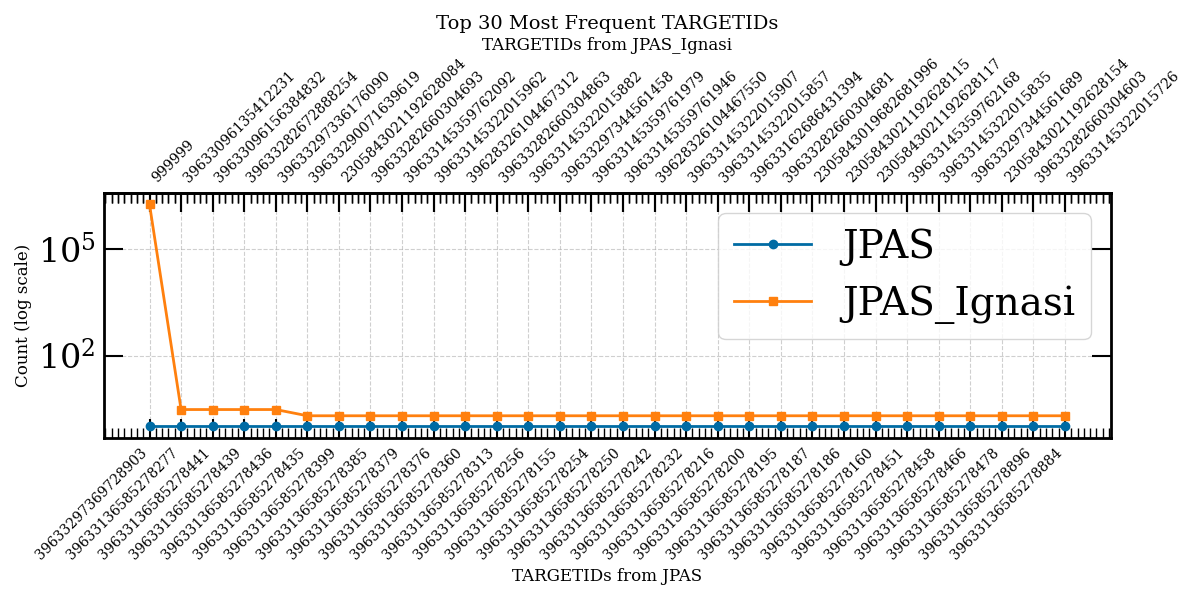

In [10]:
labels_uniques_JPAS_x_DESI_Raul, counts_uniques_JPAS_x_DESI_Raul = np.unique(DATA["JPAS_x_DESI_Raul"]['all_pd']["TARGETID"], return_counts=True)
labels_uniques_JPAS_x_DESI_Ignasi, counts_uniques_JPAS_x_DESI_Ignasi = np.unique(DATA["Ignasi"]['all_pd']["TARGETID"], return_counts=True)

print("Number of unique TARGETIDs JPAS_x_DESI_Raul:", len(labels_uniques_JPAS_x_DESI_Raul))
print("Total number of objects JPAS_x_DESI_Raul (TARGETIDs might be repeated):", np.sum(counts_uniques_JPAS_x_DESI_Raul))
print()
print("Number of unique TARGETIDs Ignasi:", len(labels_uniques_JPAS_x_DESI_Ignasi))
print("Total number of objects Ignasi (TARGETIDs might be repeated):", np.sum(counts_uniques_JPAS_x_DESI_Ignasi))

plotting_utils.plot_dual_targetid_logscale(
    labels_counts_A=(labels_uniques_JPAS_x_DESI_Raul, counts_uniques_JPAS_x_DESI_Raul),
    labels_counts_B=(labels_uniques_JPAS_x_DESI_Ignasi, counts_uniques_JPAS_x_DESI_Ignasi),
    top_n=30
)

In [11]:
IDs_only_1, IDs_only_2, IDs_both, idxs_only_1, idxs_only_2, idxs_both_1, idxs_both_2 = crossmatch_tools.crossmatch_IDs_two_datasets(
    DATA["JPAS_x_DESI_Raul"]['all_pd']["TARGETID"], DATA["Ignasi"]['all_pd']["TARGETID"]
)
print("Number of unique TARGETIDs only in JPAS-Raul:", len(IDs_only_1))
print("Number of unique TARGETIDs only in Ignasi:", len(IDs_only_2))
print("Number of unique TARGETIDs in both:", len(IDs_both))
if len(IDs_only_1) > 0:
    print("Total number of objects from JPAS-Raul, TARGETID only in JPAS-Raul (TARGETIDs might be repeated):", len(np.concatenate(idxs_only_1)))
if len(IDs_only_2) > 0:
    print("Total number of objects from  Ignasi, TARGETID only in  Ignasi (TARGETIDs might be repeated):", len(IDs_only_2))
if len(IDs_both) > 0:
    print("Total number of objects from JPAS-Raul, TARGETID in both (TARGETIDs might be repeated):", len(IDs_both))
    print("Total number of objects from  Ignasi, TARGETID in both (TARGETIDs might be repeated):", len(IDs_both))

2025-10-27 12:19:40,139 - INFO - 🔍 crossmatch_IDs_two_datasets()...
2025-10-27 12:19:40,140 - INFO - ├── 🚀 Starting ID categorization process...
2025-10-27 12:19:40,158 - INFO - |    ├── 📌 Found 122488 unique IDs across 2 arrays.
2025-10-27 12:19:40,236 - INFO - |    ├── Presence matrix created with shape: (2, 122488)
2025-10-27 12:19:40,236 - INFO - |    ├── Category mask created with shape: (2, 122488)
2025-10-27 12:19:40,237 - INFO - ├── 🚀 Starting index retrieval process...
2025-10-27 12:19:40,237 - INFO - |    ├── 📌 Processing 122488 unique IDs across 2 arrays.
2025-10-27 12:19:40,298 - INFO - ├── 🚀 Starting post-processing of unique IDs across two arrays...
2025-10-27 12:19:40,302 - INFO - |    ├── Processing complete: 21776 IDs only in Array 1 (17.78%).
2025-10-27 12:19:40,302 - INFO - |    ├── Processing complete: 70472 IDs only in Array 2 (57.53%).
2025-10-27 12:19:40,302 - INFO - |    ├── Processing complete: 30240 IDs in both arrays (24.69%).
2025-10-27 12:19:40,302 - INFO -

Number of unique TARGETIDs only in JPAS-Raul: 21776
Number of unique TARGETIDs only in Ignasi: 70472
Number of unique TARGETIDs in both: 30240
Total number of objects from JPAS-Raul, TARGETID only in JPAS-Raul (TARGETIDs might be repeated): 21776
Total number of objects from  Ignasi, TARGETID only in  Ignasi (TARGETIDs might be repeated): 70472
Total number of objects from JPAS-Raul, TARGETID in both (TARGETIDs might be repeated): 30240
Total number of objects from  Ignasi, TARGETID in both (TARGETIDs might be repeated): 30240


In [12]:
POS_JPAS_x_DESI_Raul = np.array([DATA["JPAS_x_DESI_Raul"]['all_pd']['RA'], DATA["JPAS_x_DESI_Raul"]['all_pd']['DEC']]).T
POS_Ignasi = np.array([DATA["Ignasi"]['all_pd']['JPAS_RA'], DATA["Ignasi"]['all_pd']['JPAS_DEC']]).T
mask_JPAS_x_DESI_Ignasi = DATA["Ignasi"]['all_pd']['is_in_desi_dr1']

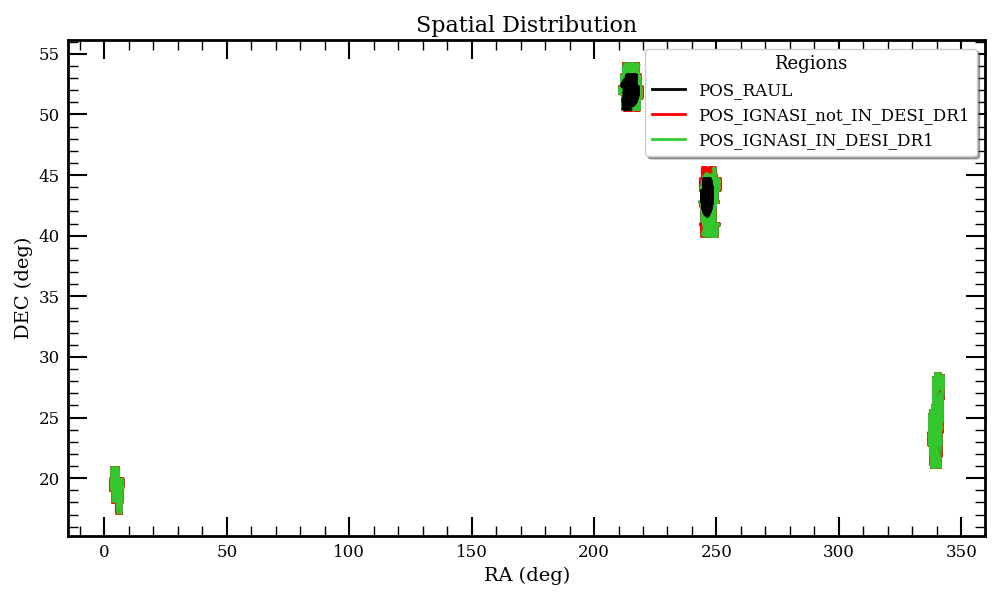

2025-10-27 12:19:43,172 - INFO - Mean nearest-neighbor distance: 0.0131 deg (0.79 arcmin)
2025-10-27 12:19:43,173 - INFO - Calculating number of neighbors within radius 3.14 arcmin (bin 1/7)
2025-10-27 12:19:43,724 - INFO - Calculating number of neighbors within radius 6.81 arcmin (bin 2/7)
2025-10-27 12:19:44,638 - INFO - Calculating number of neighbors within radius 10.48 arcmin (bin 3/7)
2025-10-27 12:19:45,933 - INFO - Calculating number of neighbors within radius 14.14 arcmin (bin 4/7)
2025-10-27 12:19:47,603 - INFO - Calculating number of neighbors within radius 17.81 arcmin (bin 5/7)
2025-10-27 12:19:49,603 - INFO - Calculating number of neighbors within radius 21.48 arcmin (bin 6/7)
2025-10-27 12:19:51,947 - INFO - Calculating number of neighbors within radius 25.14 arcmin (bin 7/7)
2025-10-27 12:19:54,618 - INFO - Completed kd-tree neighbor count calculation for 7 radius bins.
2025-10-27 12:19:54,624 - INFO - Generating histogram plot for neighbors' counts.
2025-10-27 12:19:54

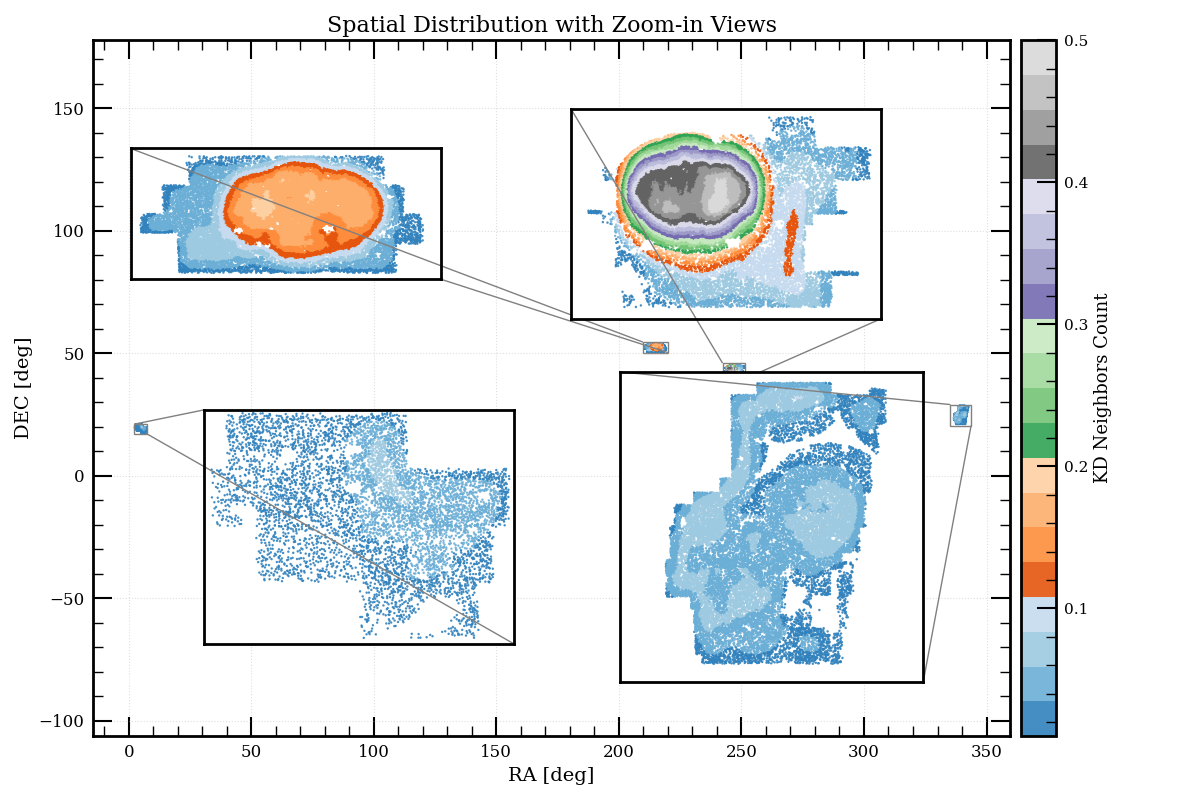

2025-10-27 12:19:55,547 - INFO - ├── 🔑 Starting encoding process for string list...
2025-10-27 12:19:55,570 - INFO - |    ├── 📌 New Mapping Created: {'main': 0, 'sv1': 1, 'sv3': 2}
2025-10-27 12:19:55,570 - INFO - │    ├── 📊 Category Breakdown (102364 total):
2025-10-27 12:19:55,570 - INFO - │    │   ├── main            → 48407 (47.29%)
2025-10-27 12:19:55,571 - INFO - │    │   ├── sv1             →  2033 (1.99%)
2025-10-27 12:19:55,571 - INFO - │    │   ├── sv3             → 51924 (50.72%)
2025-10-27 12:19:55,571 - INFO - ├── ✅ Encoding complete (3 categories + unmapped bucket if any).


['main' 'sv1' 'sv3']
[48407  2033 51924]


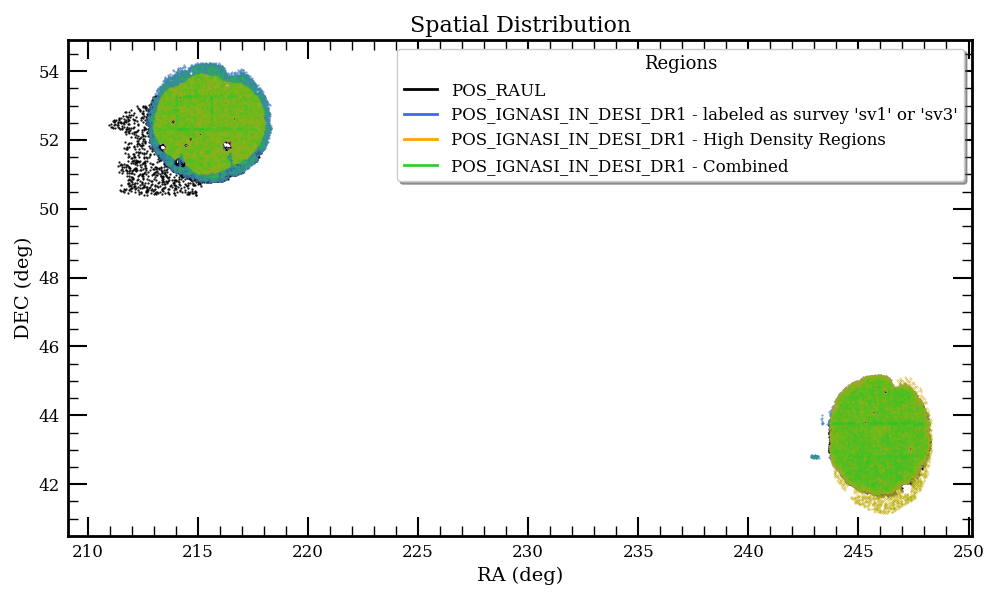

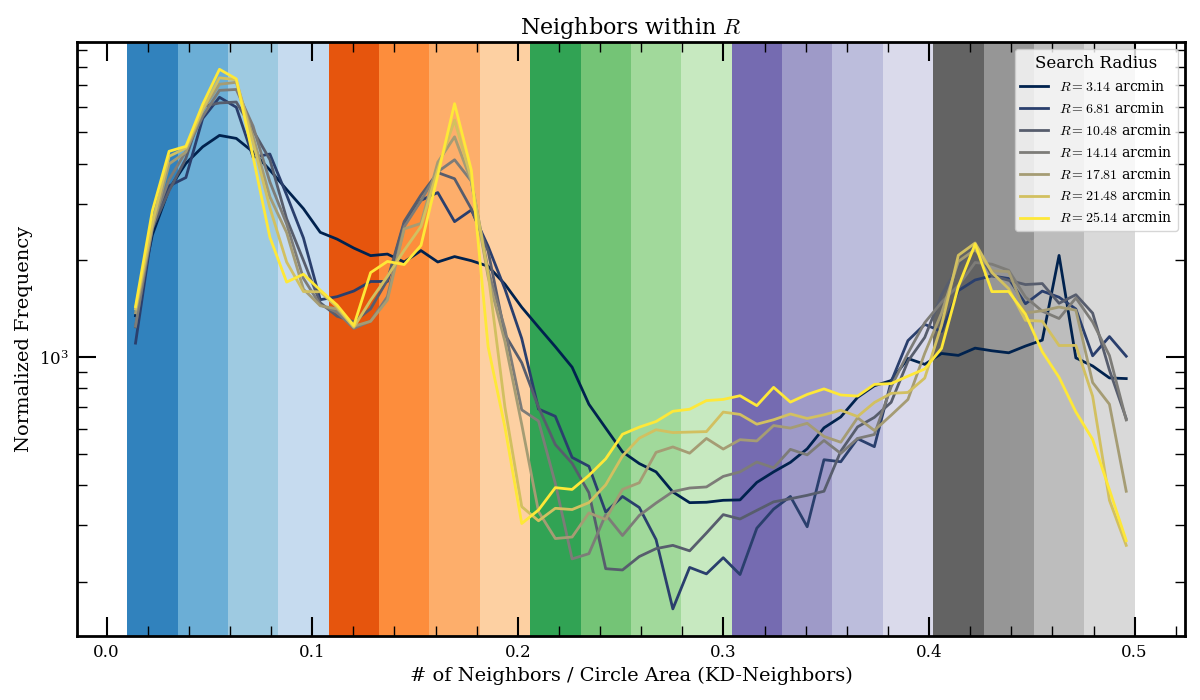

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(
    POS_Ignasi[:, 0][~mask_JPAS_x_DESI_Ignasi],
    POS_Ignasi[:, 1][~mask_JPAS_x_DESI_Ignasi],
    s=0.05, color='red', alpha=0.6
)
ax.scatter(
    POS_Ignasi[:, 0][mask_JPAS_x_DESI_Ignasi],
    POS_Ignasi[:, 1][mask_JPAS_x_DESI_Ignasi],
    s=0.05, color='limegreen', alpha=0.6
)
ax.scatter(
    POS_JPAS_x_DESI_Raul[:, 0],
    POS_JPAS_x_DESI_Raul[:, 1],
    s=0.1, color='k', alpha=0.9
)

ax.set_xlabel('RA (deg)', fontsize=14)
ax.set_ylabel('DEC (deg)', fontsize=14)
ax.set_title('Spatial Distribution', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

custom_lines = [
    mpl.lines.Line2D([0], [0], color='k', lw=2, label='POS_RAUL'),
    mpl.lines.Line2D([0], [0], color='red', lw=2, label='POS_IGNASI_not_IN_DESI_DR1'),
    mpl.lines.Line2D([0], [0], color='limegreen', lw=2, label='POS_IGNASI_IN_DESI_DR1')
]
ax.legend(handles=custom_lines, loc='upper right', fontsize=12, title="Regions", title_fontsize=13, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()




R_arcmin, kd_counts = aux_tools.compute_kd_tree_number_of_neighbors_as_function_of_radius_in_terms_of_mean_nearest_neighbor_distance(
    POS_Ignasi[mask_JPAS_x_DESI_Ignasi]
)




zoom_in_regions = {
    'min_x_array': [2.2, 209.8, 242.3, 335.3],
    'max_x_array': [7.5, 220.0, 251.6, 343.7],
    'min_y_array': [17, 50.2, 39.6, 20.4],
    'max_y_array': [21, 54.5, 45.9, 29],
    'zoom_point_sizes': [3.0, 3.0, 3.0, 3.0],
    'zoom_width': [3.1, 3.1, 3.1, 3.1],
    'zoom_height': [3.1, 3.1, 3.1, 3.1],
    'zoom_positions': [(0.1, 0.05), (0.02, 0.5), (0.5, 0.5), (0.55, 0.05)]
}
plotting_utils.plot_neighbors_and_spatial_distribution(
    kd_counts, R_arcmin, POS_Ignasi[mask_JPAS_x_DESI_Ignasi],
    min_density=0.01, max_density=0.5, zoom_in_regions=zoom_in_regions
)




labels_uniques_survey, counts_uniques_survey = np.unique(np.array(DATA["Ignasi"]['all_pd']['SURVEY'])[mask_JPAS_x_DESI_Ignasi], return_counts=True)
print(labels_uniques_survey)
print(counts_uniques_survey)




density_threshold = 0.13
mask_select_dense_KD = density_threshold < kd_counts[-1]

survey = list(np.array(DATA["Ignasi"]['all_pd']['SURVEY'])[mask_JPAS_x_DESI_Ignasi])
survey, tmp_mapping = cleaning_tools.encode_strings_to_integers(survey)
mask_select_dense_survey = ((survey == 2) | (survey == 3))

mask_select_dense = mask_select_dense_survey | mask_select_dense_KD





fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(
    POS_JPAS_x_DESI_Raul[:, 0],
    POS_JPAS_x_DESI_Raul[:, 1],
    s=0.4, color='k', alpha=0.9
)
ax.scatter(
    POS_Ignasi[:, 0][mask_JPAS_x_DESI_Ignasi][mask_select_dense_survey],
    POS_Ignasi[:, 1][mask_JPAS_x_DESI_Ignasi][mask_select_dense_survey],
    s=0.2, color='royalblue', alpha=0.8
)
ax.scatter(
    POS_Ignasi[:, 0][mask_JPAS_x_DESI_Ignasi][mask_select_dense_KD],
    POS_Ignasi[:, 1][mask_JPAS_x_DESI_Ignasi][mask_select_dense_KD],
    s=0.1, color='orange', alpha=0.7
)
ax.scatter(
    POS_Ignasi[:, 0][mask_JPAS_x_DESI_Ignasi][mask_select_dense],
    POS_Ignasi[:, 1][mask_JPAS_x_DESI_Ignasi][mask_select_dense],
    s=0.01, color='limegreen', alpha=0.6
)

ax.set_xlabel('RA (deg)', fontsize=14)
ax.set_ylabel('DEC (deg)', fontsize=14)
ax.set_title('Spatial Distribution', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

custom_lines = [
    mpl.lines.Line2D([0], [0], color='k', lw=2, label='POS_RAUL'),
    mpl.lines.Line2D([0], [0], color='royalblue', lw=2, label="POS_IGNASI_IN_DESI_DR1 - labeled as survey 'sv1' or 'sv3'"),
    mpl.lines.Line2D([0], [0], color='orange', lw=2, label='POS_IGNASI_IN_DESI_DR1 - High Density Regions'),
    mpl.lines.Line2D([0], [0], color='limegreen', lw=2, label='POS_IGNASI_IN_DESI_DR1 - Combined'),
]
ax.legend(handles=custom_lines, loc='upper right', fontsize=12, title="Regions", title_fontsize=13, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

In [14]:
TARGETID_1 = DATA["JPAS_x_DESI_Raul"]['all_pd']['TARGETID']
TARGETID_2 = DATA["Ignasi"]['all_pd']['TARGETID'][mask_JPAS_x_DESI_Ignasi]

IDs_only_1, IDs_only_2, IDs_both, idxs_only_1, idxs_only_2, idxs_both_1, idxs_both_2 = crossmatch_tools.crossmatch_IDs_two_datasets(
    TARGETID_1, TARGETID_2
)
print("Number of unique TARGETIDs only in JPAS_x_DESI_Raul:", len(IDs_only_1))
print("Number of unique TARGETIDs only in Ignasi:", len(IDs_only_2))
print("Number of unique TARGETIDs in both:", len(IDs_both))
if len(IDs_only_1) > 0:
    print("Total number of objects from JPAS_x_DESI_Raul, TARGETID only in JPAS_x_DESI_Raul (TARGETIDs might be repeated):", len(np.concatenate(idxs_only_1)))
if len(IDs_only_2) > 0:
    print("Total number of objects from Ignasi, TARGETID only in Ignasi (TARGETIDs might be repeated):", len(IDs_only_2))
if len(IDs_both) > 0:
    print("Total number of objects from JPAS_x_DESI_Raul, TARGETID in both (TARGETIDs might be repeated):", len(IDs_both))
    print("Total number of objects from Ignasi, TARGETID in both (TARGETIDs might be repeated):", len(IDs_both))

2025-10-27 12:20:43,907 - INFO - 🔍 crossmatch_IDs_two_datasets()...
2025-10-27 12:20:43,908 - INFO - ├── 🚀 Starting ID categorization process...
2025-10-27 12:20:43,913 - INFO - |    ├── 📌 Found 122487 unique IDs across 2 arrays.
2025-10-27 12:20:43,925 - INFO - |    ├── Presence matrix created with shape: (2, 122487)
2025-10-27 12:20:43,926 - INFO - |    ├── Category mask created with shape: (2, 122487)
2025-10-27 12:20:43,926 - INFO - ├── 🚀 Starting index retrieval process...
2025-10-27 12:20:43,926 - INFO - |    ├── 📌 Processing 122487 unique IDs across 2 arrays.
2025-10-27 12:20:43,974 - INFO - ├── 🚀 Starting post-processing of unique IDs across two arrays...
2025-10-27 12:20:43,978 - INFO - |    ├── Processing complete: 21776 IDs only in Array 1 (17.78%).
2025-10-27 12:20:43,978 - INFO - |    ├── Processing complete: 70471 IDs only in Array 2 (57.53%).
2025-10-27 12:20:43,979 - INFO - |    ├── Processing complete: 30240 IDs in both arrays (24.69%).
2025-10-27 12:20:43,979 - INFO -

Number of unique TARGETIDs only in JPAS_x_DESI_Raul: 21776
Number of unique TARGETIDs only in Ignasi: 70471
Number of unique TARGETIDs in both: 30240
Total number of objects from JPAS_x_DESI_Raul, TARGETID only in JPAS_x_DESI_Raul (TARGETIDs might be repeated): 21776
Total number of objects from Ignasi, TARGETID only in Ignasi (TARGETIDs might be repeated): 70471
Total number of objects from JPAS_x_DESI_Raul, TARGETID in both (TARGETIDs might be repeated): 30240
Total number of objects from Ignasi, TARGETID in both (TARGETIDs might be repeated): 30240


In [15]:
# Start with NaN and False masks
mask_in_Ignasi = np.zeros(TARGETID_1.shape, dtype=bool)
mask_dense_if_matched = np.full(TARGETID_1.shape, np.nan, dtype=float)

# Iterate only over matched IDs (still vectorized enough because IDs_both is of manageable size)
for idx_list_1, idx_list_2 in zip(idxs_both_1, idxs_both_2):
    # Get dense mask value from first match in JPAS_Ignasi
    dense_value = mask_select_dense[idx_list_2[0]]
    # Mark all corresponding entries in TARGETID_1 as matched and dense
    mask_in_Ignasi[idx_list_1] = True
    mask_dense_if_matched[idx_list_1] = dense_value
    

# Number of TARGETID_1s matched in TARGETID_2
num_matched = np.sum(mask_in_Ignasi)
print(f"✅ Matched TARGETIDs in TARGETID_2: {num_matched} / {len(TARGETID_1)}")

# Sanity: All matched should have a non-NaN value in dense mask
num_dense_nan = np.sum(np.isnan(mask_dense_if_matched[mask_in_Ignasi]))
print(f"❌ NaNs among matched dense values: {num_dense_nan}")  # Should be 0

# Optional: Count how many are marked as dense among matched ones
num_dense = np.sum(mask_dense_if_matched[mask_in_Ignasi])
print(f"🌿 Dense entries among matched: {int(num_dense)}")

# Optional: Show a few matched entries
print("\n🔍 Sample of matched TARGETIDs and their dense values:")
matched_indices = np.where(mask_in_Ignasi)[0]
for i in matched_indices[:10]:
    print(f"  TARGETID_1[{i}] = {TARGETID_1[i]} --> Dense = {mask_dense_if_matched[i]}")


print(mask_in_Ignasi.shape)
print(mask_in_Ignasi.sum())

print(mask_dense_if_matched.shape)
print(np.nansum(mask_dense_if_matched))

✅ Matched TARGETIDs in TARGETID_2: 30240 / 52016
❌ NaNs among matched dense values: 0
🌿 Dense entries among matched: 29530

🔍 Sample of matched TARGETIDs and their dense values:
  TARGETID_1[0] = 39633109771094092 --> Dense = 1.0
  TARGETID_1[1] = 39633109771095189 --> Dense = 1.0
  TARGETID_1[2] = 39633109771095391 --> Dense = 1.0
  TARGETID_1[3] = 39633109771095543 --> Dense = 1.0
  TARGETID_1[4] = 39633109771095867 --> Dense = 1.0
  TARGETID_1[5] = 39633109771095908 --> Dense = 1.0
  TARGETID_1[6] = 39633109771096014 --> Dense = 1.0
  TARGETID_1[7] = 39633109775286551 --> Dense = 1.0
  TARGETID_1[8] = 39633109775286571 --> Dense = 1.0
  TARGETID_1[9] = 39633109775286592 --> Dense = 1.0
(52016,)
30240
(52016,)
29530.0


In [16]:
colors = ['k', 'purple', 'blue', 'green', 'orange', 'red']
magnitude_ranges = [(15, 17), (17, 19), (19, 21), (21, 22), (22, 22.5), (22.5, 25)]
print(magnitude_ranges[1:-1])

[(17, 19), (19, 21), (21, 22), (22, 22.5)]


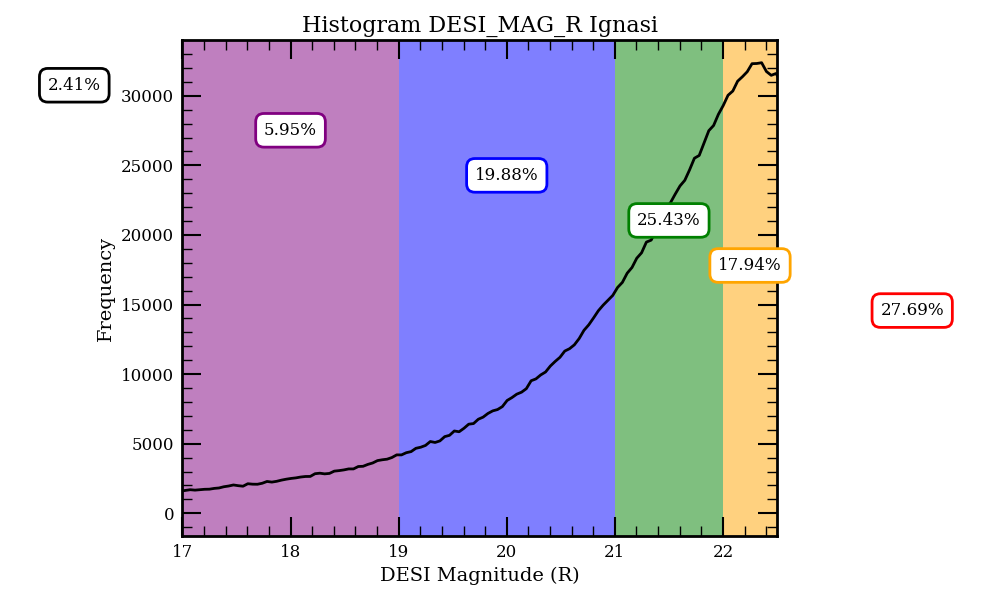

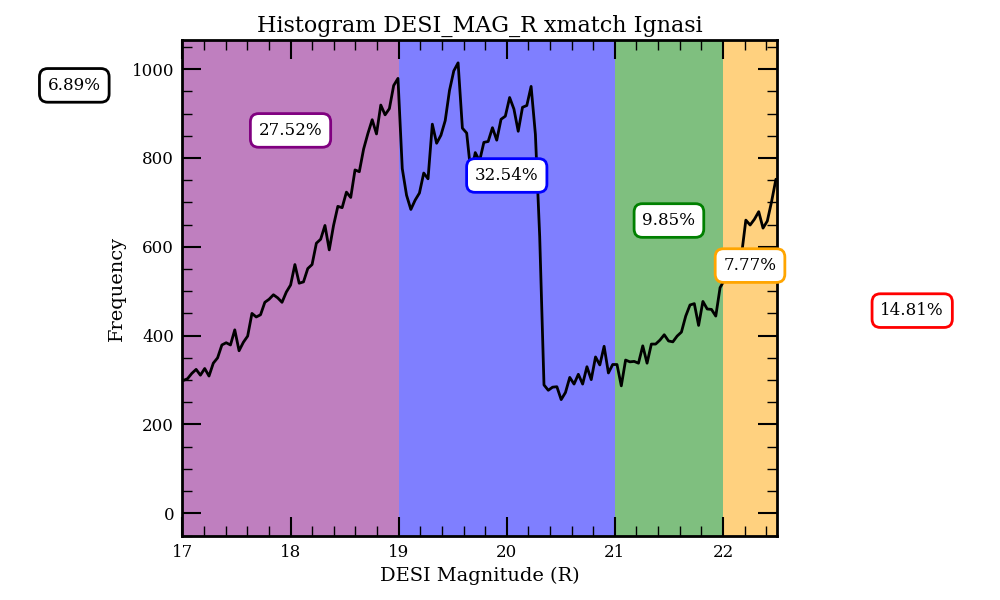

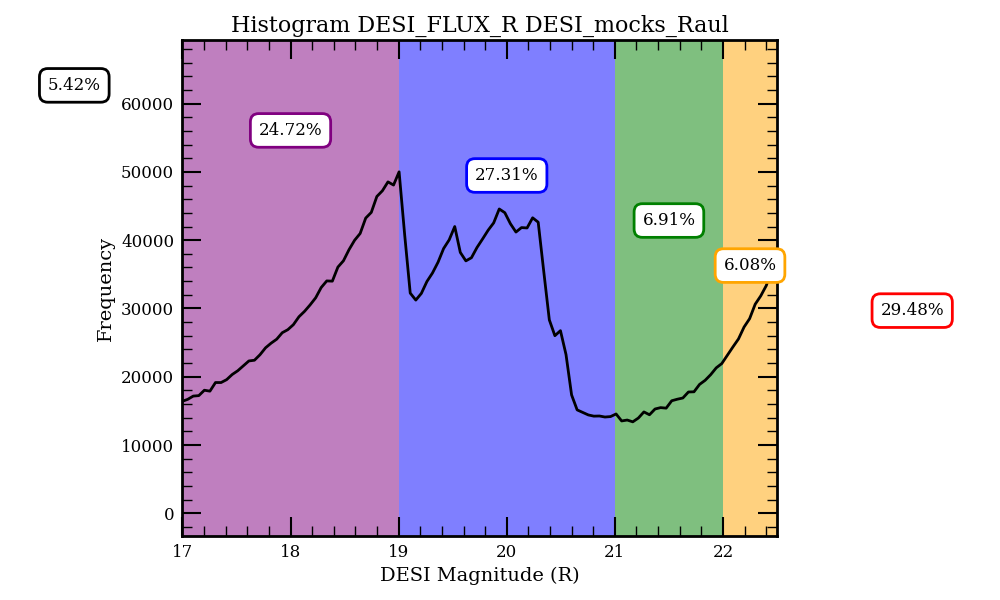

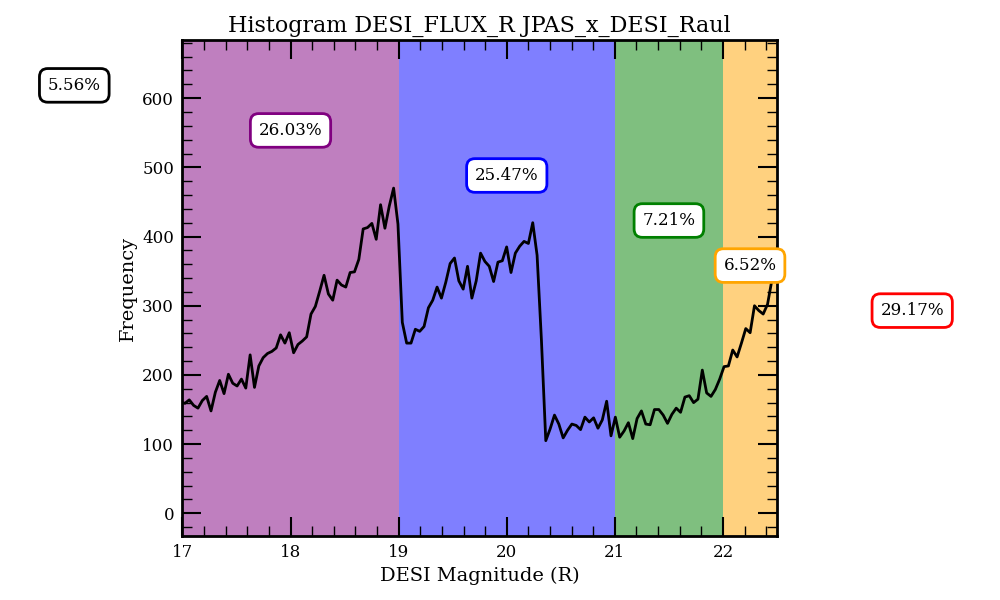

In [17]:
x_range = (magnitude_ranges[0][1], magnitude_ranges[-1][-2])

key = 'Ignasi'
magnitudes_all = DATA[key]['all_pd']['DESI_MAG_R']
mask_finite_R_all = ~np.isinf(magnitudes_all)
magnitudes_all_finite = magnitudes_all[mask_finite_R_all]
masks_R_magnitudes_all_finite = plotting_utils.plot_histogram_with_ranges(
    magnitudes_all_finite, ranges=magnitude_ranges, colors=colors, bins=300,
    x_label='DESI Magnitude (R)', title='Histogram DESI_MAG_R ' + key,
    x_range=x_range
)

key = 'Ignasi'
magnitudes_in_DESI = DATA[key]['all_pd']['DESI_MAG_R'][mask_JPAS_x_DESI_Ignasi]
mask_finite_R_in_DESI = ~np.isinf(magnitudes_in_DESI)
magnitudes_in_DESI_finite = magnitudes_in_DESI[mask_finite_R_in_DESI]
masks_R_magnitudes_in_DESI_finite = plotting_utils.plot_histogram_with_ranges(
    magnitudes_in_DESI_finite, ranges=magnitude_ranges, colors=colors, bins=300,
    x_label='DESI Magnitude (R)', title='Histogram DESI_MAG_R xmatch ' + key,
    x_range=x_range
)

key = 'DESI_mocks_Raul'
magnitudes_ = -2.5 * np.log10(DATA[key]['all_pd']['DESI_FLUX_R']) + 22.5
mask_finite_ = ~np.isinf(magnitudes_)
magnitudes_finite = magnitudes_[mask_finite_]
masks_R_magnitudes_in_DESI_finite = plotting_utils.plot_histogram_with_ranges(
    magnitudes_finite, ranges=magnitude_ranges, colors=colors, bins=300,
    x_label='DESI Magnitude (R)', title='Histogram DESI_FLUX_R ' + key,
    x_range=x_range
)

key = 'JPAS_x_DESI_Raul'
magnitudes_ = -2.5 * np.log10(DATA[key]['all_pd']['DESI_FLUX_R']) + 22.5
mask_finite_ = ~np.isinf(magnitudes_)
magnitudes_finite = magnitudes_[mask_finite_]
masks_R_magnitudes_in_DESI_finite = plotting_utils.plot_histogram_with_ranges(
    magnitudes_finite, ranges=magnitude_ranges, colors=colors, bins=300,
    x_label='DESI Magnitude (R)', title='Histogram DESI_FLUX_R ' + key,
    x_range=x_range
)

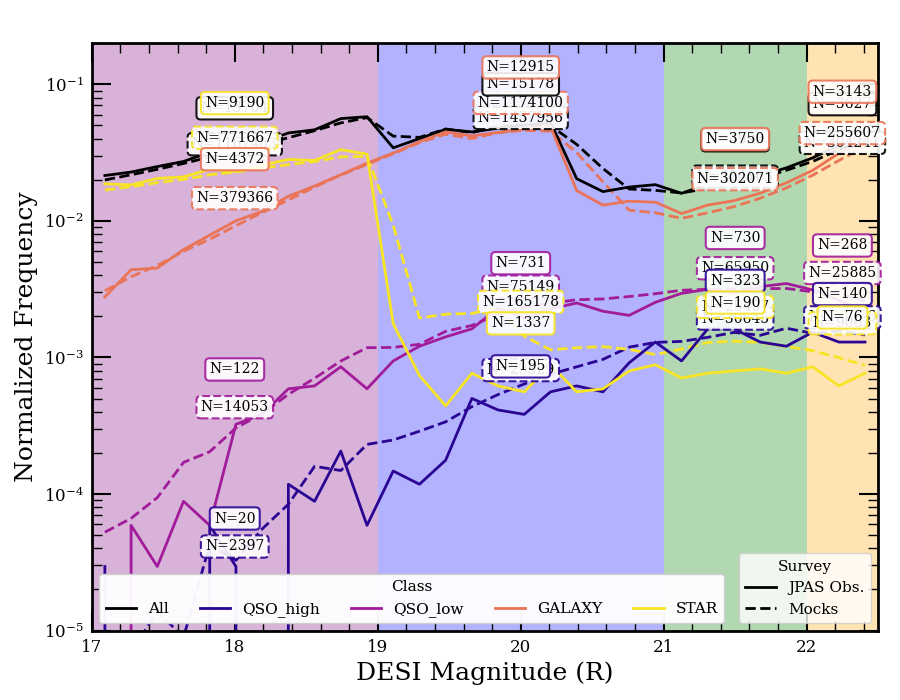

In [18]:
# Style maps
survey_styles = {
    "JPAS_x_DESI_Raul": "-",
    "DESI_mocks_Raul":  "--",
}
survey_labels = {
    "JPAS_x_DESI_Raul": "JPAS Obs.",
    "DESI_mocks_Raul":  "Mocks",
}
class_colors = {
    "All": "black",
    "QSO_high": [0.16407 , 0.020171, 0.577478, 1.      ],
    "QSO_low":  [0.631017, 0.107699, 0.608287, 1.      ],
    "GALAXY":   [0.918109, 0.453603, 0.339529, 1.      ],
    "STAR":     [0.968443, 0.894564, 0.147014, 1.      ],
}
class_labels = {k: k for k in class_colors.keys()}

def _to_mag(arr):
    mags = -2.5 * np.log10(np.asarray(arr)) + 22.5
    return mags[np.isfinite(mags)]

series = []
for ds in ("DESI_mocks_Raul", "JPAS_x_DESI_Raul"):
    # All
    vals_all = _to_mag(DATA[ds]["all_pd"]["DESI_FLUX_R"])
    series.append({
        "values": vals_all, "survey": ds, "cls": "All",
        "label": f"{survey_labels[ds]} · All"
    })
    # Per SPECTYPE
    spectype = np.asarray(DATA[ds]["all_pd"]["SPECTYPE"]).astype(object)
    for sp in ("QSO_high", "QSO_low", "GALAXY", "STAR"):
        mask = (spectype == sp)
        vals = _to_mag(np.asarray(DATA[ds]["all_pd"]["DESI_FLUX_R"])[mask])
        if vals.size == 0:
            continue
        series.append({
            "values": vals, "survey": ds, "cls": sp,
            "label": f"{survey_labels[ds]} · {sp}"
        })

fig, ax = plotting_utils.plot_multi_histograms_two_legends(
    series=series,
    ranges=magnitude_ranges[1:-1],
    range_colors=colors[1:-1],
    bins=30,  # default if a series doesn't specify its own
    survey_styles=survey_styles,
    survey_labels=survey_labels,
    class_colors=class_colors,
    class_labels=class_labels,
    x_label="DESI Magnitude (R)",
    y_label="Normalized Frequency",  # optional custom label
    title=None,
    figsize=(9, 7),
    x_range=(magnitude_ranges[1][0], magnitude_ranges[-2][-1]),
    # legends
    show_survey_legend=True, survey_legend_loc="lower right",
    show_class_legend=True,  class_legend_loc="lower left",
    legend_fontsize=11,
    # scaling & labels
    logy=True,                 # can set True if desired
    label_on_curve=False,       # keep just the band boxes
    # band boxes
    show_band_counts=True,
    band_box_alpha=0.9,
    band_box_pad=0.3,
    band_fontsize=10,
    band_y_offset_frac=0.0,
    band_y_offset_dec=0.0,
    band_series_vstack=0.05,
    band_series_vstack_dec=0.05,
    linewidth=2.0,
)
ax.set_ylim(0.00001, 0.2)
fig.savefig(os.path.join(global_setup.path_saved_figures, "histogram_Mocks_Obs_class_distributions_mag_bins.pdf"))
plt.show()

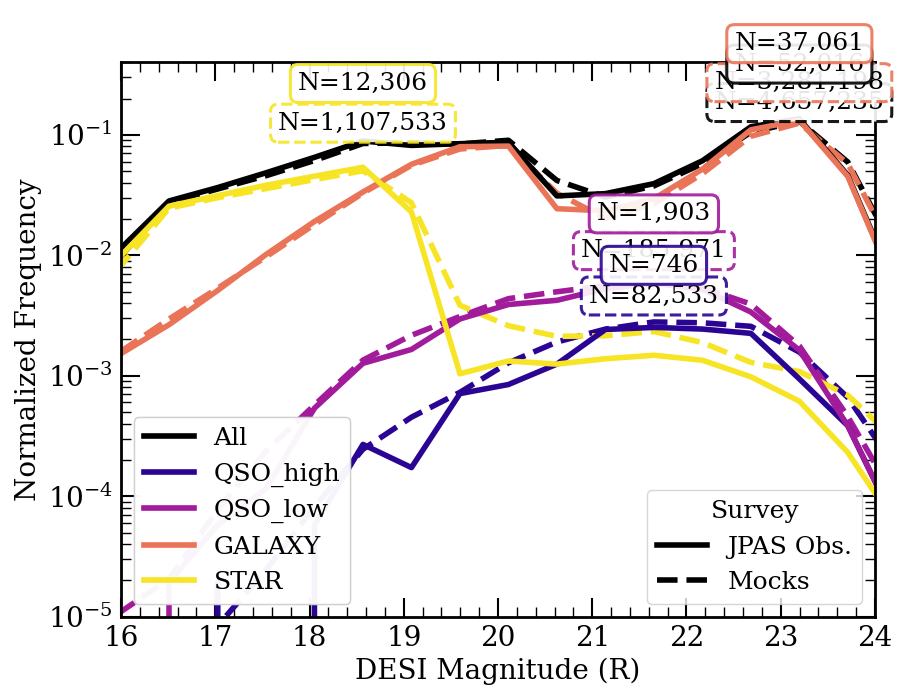

In [19]:
fig, ax = plotting_utils.plot_multi_histograms_two_legends_new(
    series=series,
    # no ranges / range_colors → no shaded bands
    bins=30,
    survey_styles=survey_styles,
    survey_labels=survey_labels,
    class_colors=class_colors,
    class_labels=class_labels,
    x_label="DESI Magnitude (R)",
    y_label="Normalized Frequency",
    title=None,
    # x_range=None means use the full data range
    x_range=None,
    figsize=(9, 7),
    # legends
    show_survey_legend=True, survey_legend_loc="lower right",
    show_class_legend=True,  class_legend_loc="lower left",
    legend_fontsize=18,
    # scaling & labels
    logy=True,
    label_on_curve=True,          # one label per curve
    curve_label_mode="count",     # show only N={N}
    total_label_fmt="N={N:,}",    # e.g., N=12,345
    # disable old band boxes
    show_band_counts=False,
    # aesthetics
    linewidth=4.0,
)
ax.set_xlim(16, 24)
ax.set_ylim(0.00001, 0.4)
# fig.savefig(os.path.join(global_setup.path_saved_figures, "histogram_Mocks_Obs_class_distributions.pdf"))
plt.show()


2025-10-27 12:24:45,646 - INFO - ├── 🔑 Starting encoding process for string list...
2025-10-27 12:24:45,672 - INFO - |    ├── 📌 New Mapping Created: {'GALAXY': 0, 'QSO_high': 1, 'QSO_low': 2, 'STAR': 3}
2025-10-27 12:24:45,673 - INFO - │    ├── 📊 Category Breakdown (102364 total):
2025-10-27 12:24:45,673 - INFO - │    │   ├── GALAXY          → 65725 (64.21%)
2025-10-27 12:24:45,673 - INFO - │    │   ├── QSO_high        →  2305 (2.25%)
2025-10-27 12:24:45,674 - INFO - │    │   ├── QSO_low         →  6456 (6.31%)
2025-10-27 12:24:45,674 - INFO - │    │   ├── STAR            → 27878 (27.23%)
2025-10-27 12:24:45,674 - INFO - ├── ✅ Encoding complete (4 categories + unmapped bucket if any).


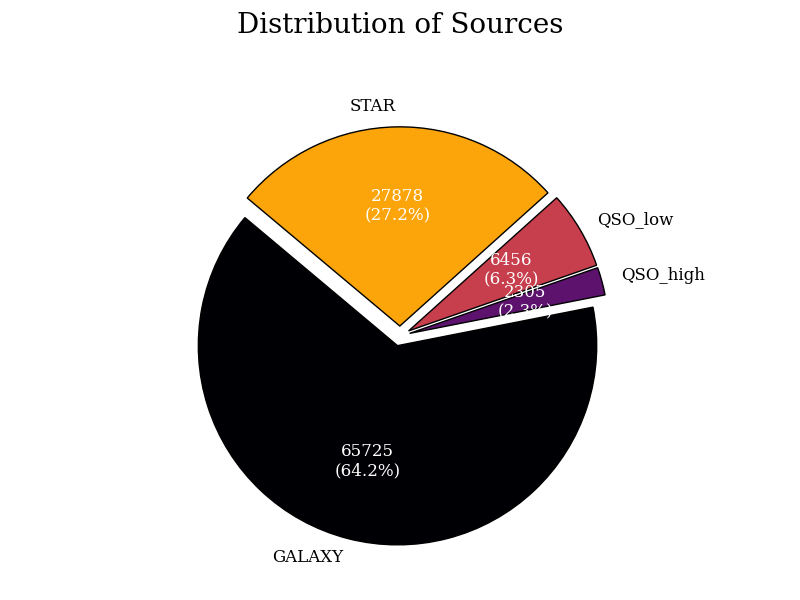

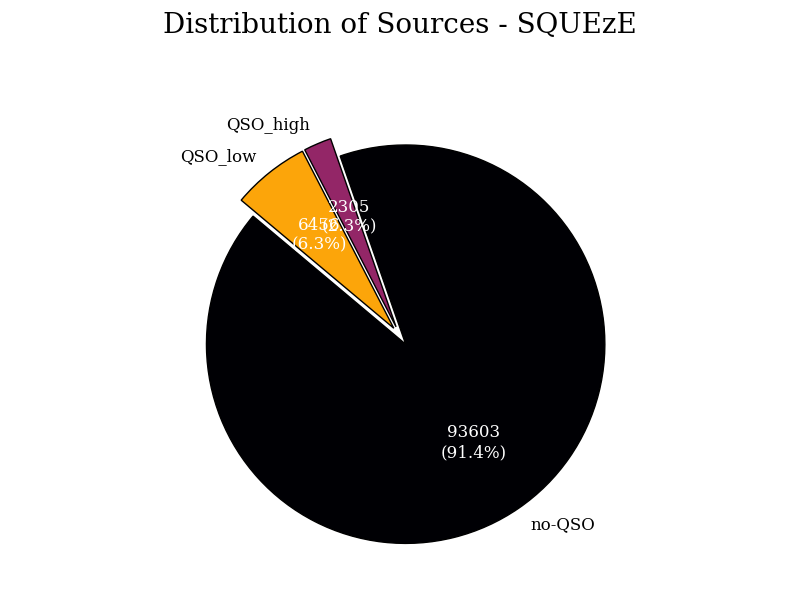

In [20]:
yy_true = np.array(DATA["Ignasi"]['all_pd']['SPECTYPE'])[mask_JPAS_x_DESI_Ignasi]
yy_true = list(np.array(yy_true).astype(np.str_))

REDSHIFT = np.array(DATA["Ignasi"]['all_pd']['z'][mask_JPAS_x_DESI_Ignasi])

# Split between High and Low redshift quasars
z_lim_QSO_cut = 2.1
for ii in range(len(yy_true)):
    if yy_true[ii] == "QSO":
        if REDSHIFT[ii] < z_lim_QSO_cut:
            yy_true[ii] = "QSO_low"
        else:
            yy_true[ii] = "QSO_high"

yy_true, class_mapping = cleaning_tools.encode_strings_to_integers(yy_true)
class_names = list(class_mapping.keys())

unique_spectype_names, counts = np.unique(yy_true, return_counts=True)
plotting_utils.plot_pie_chart(labels=unique_spectype_names, counts=counts, title="Sources", class_names=class_names)

# y_true For SQUEzE
yy_true_SQUEzE = np.zeros_like(yy_true)
mask_no_QSO = (yy_true == 0) | (yy_true == 3)
mask_hQSO = (yy_true == 1)
mask_lQSO = (yy_true == 2)
yy_true_SQUEzE[mask_no_QSO] = 0
yy_true_SQUEzE[mask_hQSO] = 1
yy_true_SQUEzE[mask_lQSO] = 2

class_names_SQUEzE = ["no-QSO", "QSO_high", "QSO_low"]

unique_spectype_names_SQUEzE, counts_SQUEzE = np.unique(yy_true_SQUEzE, return_counts=True)
plotting_utils.plot_pie_chart(labels=unique_spectype_names_SQUEzE, counts=counts_SQUEzE, title="Sources - SQUEzE", class_names=class_names_SQUEzE)

In [21]:
classification_keys = {
    "TRANS" : ['conf_gal_TRANS', 'conf_hqso_TRANS', 'conf_lqso_TRANS', 'conf_star_TRANS'],
    "CBM"   : ['conf_gal_CBM', 'conf_hqso_CBM', 'conf_lqso_CBM', 'conf_star_CBM']
}

yy_pred_P = {}
for ii, key in enumerate(classification_keys):
    yy_pred_P[key] = []
    for jj, key_type in enumerate(classification_keys[key]):
        yy_pred_P[key].append(np.array(DATA["Ignasi"]['all_pd'][key_type][mask_JPAS_x_DESI_Ignasi]))
    yy_pred_P[key] = np.array(yy_pred_P[key]).T
    yy_pred_P[key] = yy_pred_P[key][mask_select_dense]  # select only dense regions
yy_true = yy_true[mask_select_dense]                    # select only dense regions

# tmp_SQUEzE = np.array(JPAS_Ignasi['class_SQUEzE'][JPAS_Ignasi["is_in_desi_dr1"]])
# yy_pred_P["SQUEzE"] = np.column_stack([
#     (tmp_SQUEzE == -1).astype(int),   # Not QSO
#     (tmp_SQUEzE == 2).astype(int),    # Low-QSO
#     (tmp_SQUEzE == 3).astype(int)     # High-QSO
# ]).astype(np.float64)

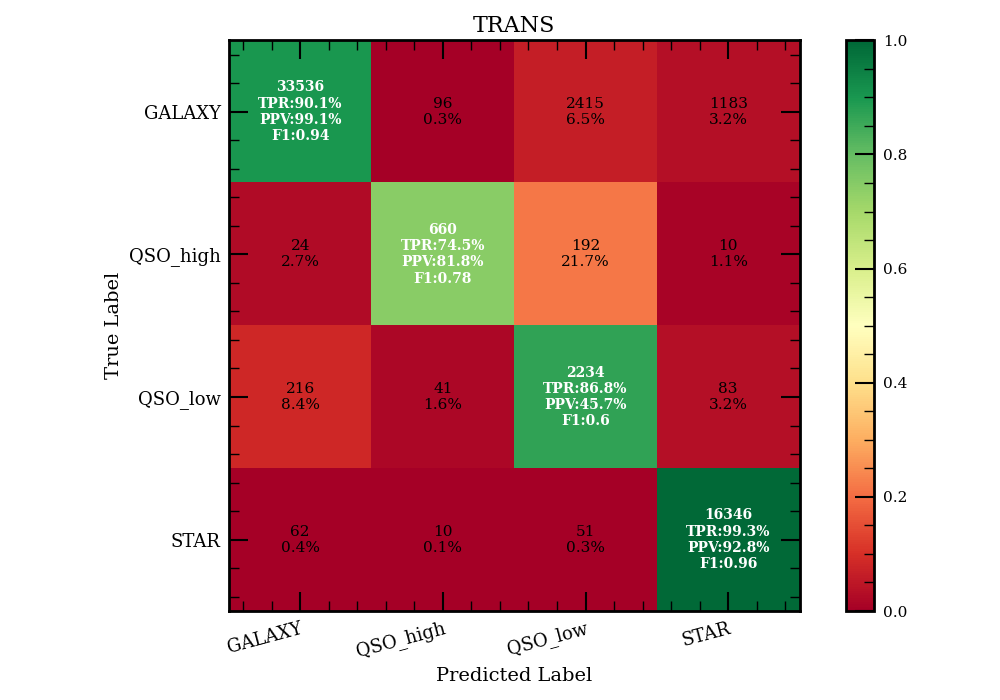

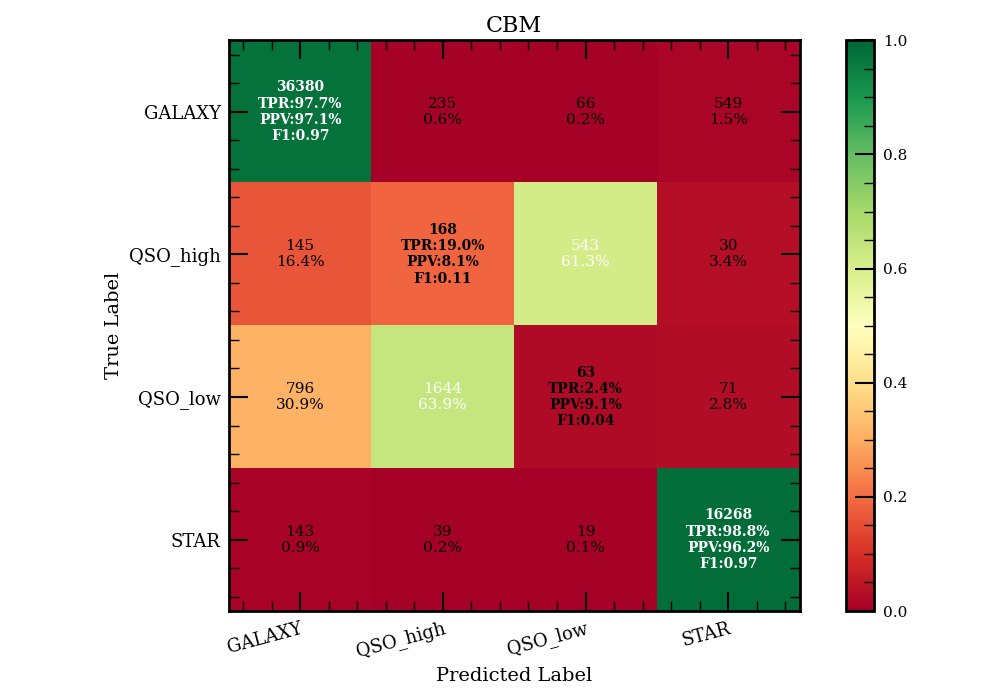

In [22]:
for ii, key in enumerate(classification_keys):
    evaluation_tools.plot_confusion_matrix(
        yy_true, yy_pred_P[key],
        class_names=class_names,
        cmap=plt.cm.RdYlGn, title=key
    )

# evaluation_tools.plot_confusion_matrix(
#     yy_true_SQUEzE, yy_pred_P["SQUEzE"],
#     class_names=class_names_SQUEzE,
#     cmap=plt.cm.RdYlGn, title="SQUEzE"
# )

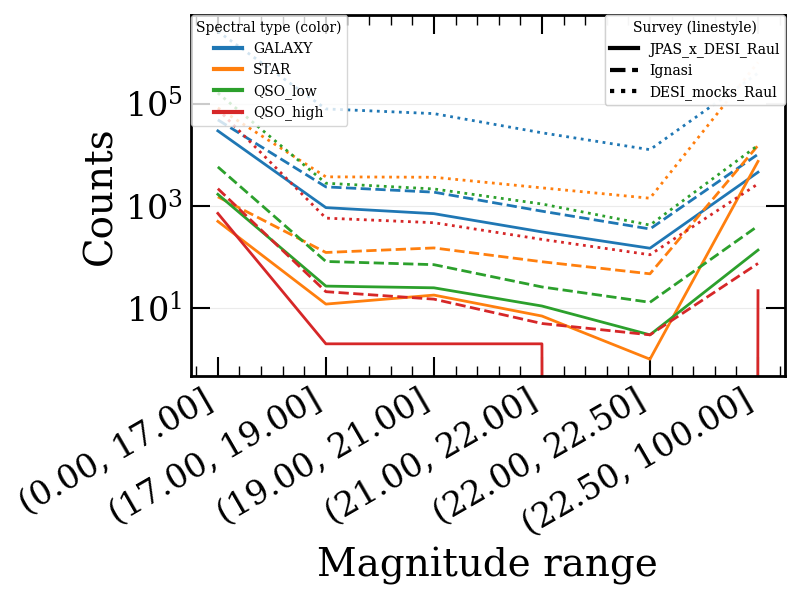

In [23]:
# --- user-configurable inputs -------------------------------------------------
magnitude_key = "DESI_FLUX_R"
mag_bin_edges = (0, 17, 19, 21, 22, 22.5, 100)
survey_keys = ["JPAS_x_DESI_Raul", "Ignasi", "DESI_mocks_Raul"]

linestyle_map = {
    "JPAS_x_DESI_Raul"  : "-",
    "Ignasi": "--",
    "DESI_mocks_Raul"   : ":",
}
# -----------------------------------------------------------------------------


# prepare bins and x-axis labels
magnitude_ranges = [(mag_bin_edges[i], mag_bin_edges[i+1]) for i in range(len(mag_bin_edges)-1)]
x = np.arange(len(magnitude_ranges))
xticklabels = [f"({lo:.2f}, {hi:.2f}]" for (lo, hi) in magnitude_ranges]

# collect surveys that are available in `data` and contain needed fields
available = []
for sk in survey_keys:
    if sk not in DATA:
        continue
    pd = DATA[sk].get("all_pd", {})
    if magnitude_key in pd and "SPECTYPE" in pd:
        available.append(sk)

if not available:
    raise RuntimeError("None of the requested surveys are available in `DATA` with the required keys.")

# build a global, stable class order by overall frequency across all selected surveys
all_spectypes = []
for sk in available:
    all_spectypes.append(np.asarray(DATA[sk]["all_pd"]["SPECTYPE"]))
all_spectypes = np.concatenate(all_spectypes)
all_spectypes = all_spectypes[all_spectypes != ""]
classes, global_counts = np.unique(all_spectypes, return_counts=True)
classes = classes[np.argsort(-global_counts)]  # most frequent first
n_classes = len(classes)
n_bins = len(magnitude_ranges)

# precompute counts per survey: dict[survey] -> (n_classes, n_bins)
counts_by_survey = {}
bin_totals_by_survey = {}

for sk in available:
    magnitude = np.asarray(DATA[sk]["all_pd"][magnitude_key])
    spectype  = np.asarray(DATA[sk]["all_pd"]["SPECTYPE"])

    counts = np.zeros((n_classes, n_bins), dtype=int)
    bin_totals = np.zeros(n_bins, dtype=int)
    cls_to_row = {cls: i for i, cls in enumerate(classes)}

    for j, (lo, hi) in enumerate(magnitude_ranges):
        mask = (magnitude > lo) & (magnitude <= hi)  # (low, high]
        bin_totals[j] = int(mask.sum())
        if bin_totals[j] == 0:
            continue
        sp_bin = spectype[mask]
        u, c = np.unique(sp_bin, return_counts=True)
        for cls, cnt in zip(u, c):
            if cls in cls_to_row:
                counts[cls_to_row[cls], j] = cnt

    counts_by_survey[sk] = counts
    bin_totals_by_survey[sk] = bin_totals

# plotting
fig, ax = plt.subplots(figsize=(8, 6))
cmap = plt.get_cmap("tab20" if n_classes > 10 else "tab10")

# plot: for each class (fixed color), overlay one line per survey (different linestyle)
for i, cls in enumerate(classes):
    color = cmap(i % cmap.N)
    for sk in available:
        ax.plot(
            x,
            counts_by_survey[sk][i],
            linestyle=linestyle_map.get(sk, "-"),
            linewidth=2.0,
            color=color,
        )

# axes cosmetics
ax.set_xlabel("Magnitude range")
ax.set_ylabel("Counts")
ax.set_xticks(x)
ax.set_xticklabels(xticklabels, rotation=30, ha="right")
ax.set_yscale("log")
ax.grid(True, which="both", axis="y", alpha=0.25)

# legends: colors = classes, linestyles = surveys
class_handles = [
    Line2D([0], [0], color=cmap(i % cmap.N), lw=3, label=str(cls))
    for i, cls in enumerate(classes)
]
survey_handles = [
    Line2D([0], [0], color="black", lw=3, linestyle=linestyle_map.get(sk, "-"), label=sk)
    for sk in available
]

# place legends
leg1 = ax.legend(
    handles=class_handles,
    title="Spectral type (color)",
    loc="upper left",
    borderaxespad=0.0, fontsize=10,
    ncol=1,
)
ax.add_artist(leg1)
leg2 = ax.legend(
    handles=survey_handles,
    title="Survey (linestyle)",
    loc="upper right",
    borderaxespad=0.0, fontsize=10,
    ncol=1,
)
ax.add_artist(leg2)

plt.tight_layout()
plt.show()

In [24]:
print(DATA.keys())
print()
print(DATA['JPAS_x_DESI_Raul'].keys())
print(DATA['DESI_mocks_Raul'].keys())
print(DATA['Ignasi'].keys())
print()
print(DATA['JPAS_x_DESI_Raul']['all_observations'].shape)
print(DATA['DESI_mocks_Raul']['all_observations'].shape)
print(DATA['Ignasi']['all_observations'].shape)
print()
print(DATA['JPAS_x_DESI_Raul']['all_pd']['TARGETID'].shape)
print(DATA['DESI_mocks_Raul']['all_pd']['TARGETID'].shape)
print(DATA['Ignasi']['all_pd']['TARGETID'].shape)
print()

dict_keys(['JPAS_x_DESI_Raul', 'DESI_mocks_Raul', 'Ignasi'])

dict_keys(['all_pd', 'all_observations', 'all_errors', 'all_observations_normalized', 'all_errors_normalized', 'normalization'])
dict_keys(['all_pd', 'all_observations', 'all_errors', 'all_observations_normalized', 'all_errors_normalized', 'normalization'])
dict_keys(['all_pd', 'all_observations', 'all_errors', 'all_observations_normalized', 'all_errors_normalized', 'normalization'])

(52016, 55)
(4657235, 55)
(1968691, 55)

(52016,)
(4657235,)
(1968691,)



2025-10-27 12:24:48,105 - INFO - ├── 🚀 Starting ID categorization process...
2025-10-27 12:24:48,355 - INFO - |    ├── 📌 Found 1557643 unique IDs across 3 arrays.
2025-10-27 12:24:49,426 - INFO - |    ├── Presence matrix created with shape: (3, 1557643)
2025-10-27 12:24:49,433 - INFO - |    ├── Category mask created with shape: (3, 1557643)
2025-10-27 12:24:49,434 - INFO - ├── 🚀 Starting index retrieval process...
2025-10-27 12:24:49,435 - INFO - |    ├── 📌 Processing 1557643 unique IDs across 3 arrays.


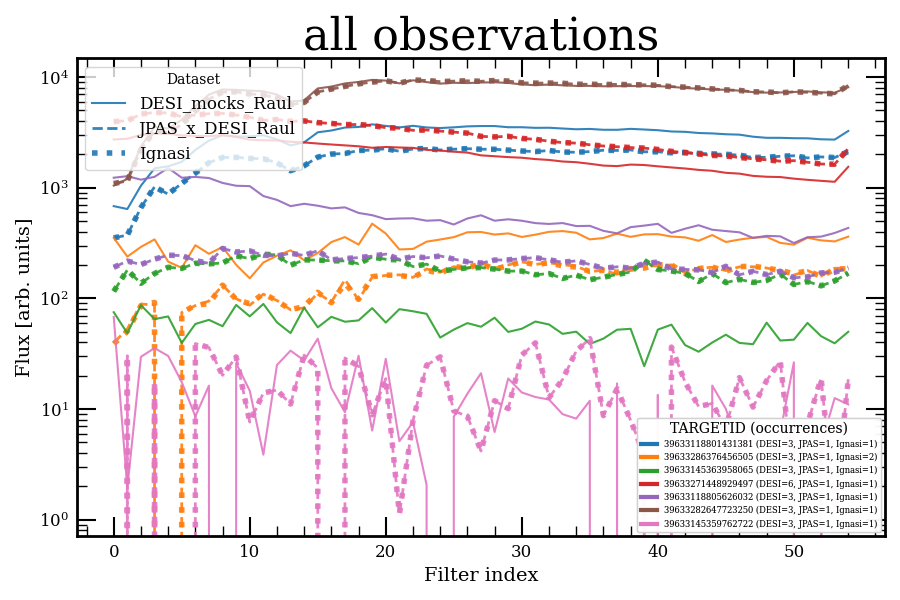

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- Choose raw vs normalized observations
obs_key = "all_observations"

# --- Pull TARGETIDs
ids_jpas   = np.asarray(DATA['JPAS_x_DESI_Raul']['all_pd']['TARGETID'])
ids_desi   = np.asarray(DATA['DESI_mocks_Raul']['all_pd']['TARGETID'])
ids_ignasi = np.asarray(DATA['Ignasi']['all_pd']['TARGETID'])

# --- 3-way intersection using your helpers
unique_ids, _, presence_mask = crossmatch_tools.categorize_ids([ids_jpas, ids_desi, ids_ignasi])
inter_rows = np.flatnonzero(presence_mask.all(axis=0))

indices_matrix = crossmatch_tools.get_all_indices([ids_jpas, ids_desi, ids_ignasi], unique_ids)

# --- Subsample which IDs to plot
NN_plot = 7
rng = np.random.default_rng(42)
sample_rows = rng.choice(inter_rows, size=min(NN_plot, inter_rows.size), replace=False)

# --- Plot setup
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_xlabel(r'Filter index', fontsize=14)
ax.set_ylabel(r'Flux [arb. units]', fontsize=14)
ax.set_yscale("log")

# One color per TARGETID; linestyle & linewidth per dataset
ds_order   = ['DESI_mocks_Raul', 'JPAS_x_DESI_Raul', 'Ignasi']
# columns correspond to the order used in categorize_ids above
col_index  = {'JPAS_x_DESI_Raul': 0, 'DESI_mocks_Raul': 1, 'Ignasi': 2}
linestyles = {'DESI_mocks_Raul': '-', 'JPAS_x_DESI_Raul': '--', 'Ignasi': ':'}
linewidths = {'DESI_mocks_Raul': 1.5, 'JPAS_x_DESI_Raul': 2., 'Ignasi': 4.}
default_lw = 1.6

cmap = plt.cm.tab10

# Track first-legend (datasets) so it only lists each dataset once
labeled_dataset = {k: False for k in ds_order}

# For custom legend of IDs with occurrence counts
id_handles = []

for i, row in enumerate(sample_rows):
    target_id = unique_ids[row]
    color = cmap(i % 10)

    # Count occurrences and plot FIRST occurrence only
    counts = {}
    for ds in ds_order:
        c = col_index[ds]
        idxs = np.atleast_1d(indices_matrix[row, c])
        counts[ds] = len(idxs)

        # safety: intersection should guarantee >=1, but be robust
        if len(idxs) == 0:
            continue

        # plot first occurrence only
        ridx = int(idxs[0])
        # sanity check: same TARGETID
        assert DATA[ds]['all_pd']['TARGETID'][ridx] == target_id, f"TARGETID mismatch in {ds}"

        y = np.asarray(DATA[ds][obs_key][ridx], dtype=float)
        x = np.arange(y.size)
        lbl = ds if not labeled_dataset[ds] else None
        ax.plot(
            x, y,
            linestyles[ds],
            lw=linewidths.get(ds, default_lw),  # <-- use per-dataset linewidth
            alpha=0.9,
            color=color,
            label=lbl
        )

        labeled_dataset[ds] = True

    # Build a colored dummy handle for the custom legend
    id_label = f"{int(target_id)} (DESI={counts['DESI_mocks_Raul']}, JPAS={counts['JPAS_x_DESI_Raul']}, Ignasi={counts['Ignasi']})"
    id_handles.append(Line2D([0], [0], color=color, lw=3, label=id_label))

# Legend 1: datasets (linestyles)
leg1 = ax.legend(title="Dataset", frameon=True, loc="upper left", fontsize=12)
ax.add_artist(leg1)

# Legend 2: TARGETIDs with occurrence counts (colored by ID)
leg2 = ax.legend(handles=id_handles, frameon=True, title="TARGETID (occurrences)", loc="lower right", fontsize=6)
ax.add_artist(leg2)

ax.tick_params(axis='both', labelsize=12)
ax.set_title(f"{obs_key.replace('_', ' ')}")
plt.tight_layout()
plt.show()